### Week 6: Section
Adapted by Misha Gupta (2024), from Aoyue Mao 2021,, Danylo Lavrentovich 2020, Irina Shlosman 2019 and Kevin Mizes 2018

### What's in this notebook

- A concrete example of computing a p-value under a null hypothesis with a binomial problem
- General overview of estimating parameters from data and building new hypotheses given data
- Maximum likelihood estimation of parameters for binomial, normal
- How T distribution arises from estimation of normal parameters
- Practice problems

We encourage you to run the examples here and try different parameter settings. To be able to run the code, make sure you download this [helper python file](w06_section_utils.py)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from w06_section_utils import set_font_sizes, viz_coin_flip_H0_H1, estimate_normal_from_sample, get_dist_of_xbar_and_S
set_font_sizes() # override matplotlib default plotting settings with bigger font sizes

### Null hypothesis & computing a p-value

Example: You are at a fair and you encounter an intriguing booth offering you 15 dollars straight up if you enter their game. What's the catch? You are also given a coin with an ominous cartoon face on it. You are asked to flip the coin $N=30$ times -- each time it lands on heads, your cash reward goes down 1 dollar. "It's a fair coin, I promise you!" the booth manager says...

You take them at their word, the immediate cash on hand is enticing... and you flip heads 25 times out of 30. You suddenly owe the booth manager 10 dollars.

You know you're a pretty unlucky person. But this seems like an especially embarrassing episode. If the coin really was fair, as the booth manager asserted, what is the chance we'd be this or MORE unlucky?

The number of heads we'd expect to observe out of $N=30$ flips is well modeled by a binomial process ($N$ independent trials/flips, each flip has some probability of heads $p$, and we're interested in knowing the total number of heads we record). For any $p$:

$$P(\text{$k$ heads out of $N$ trials} \mid p) = {N \choose k} p^k (1-p)^{N-k}$$

Let's plot out the probability mass function and the cumulative distribution function of $k$, the number of heads in $N=30$ flips, assuming $p=0.5$, and mark our unlucky $k = 25$:

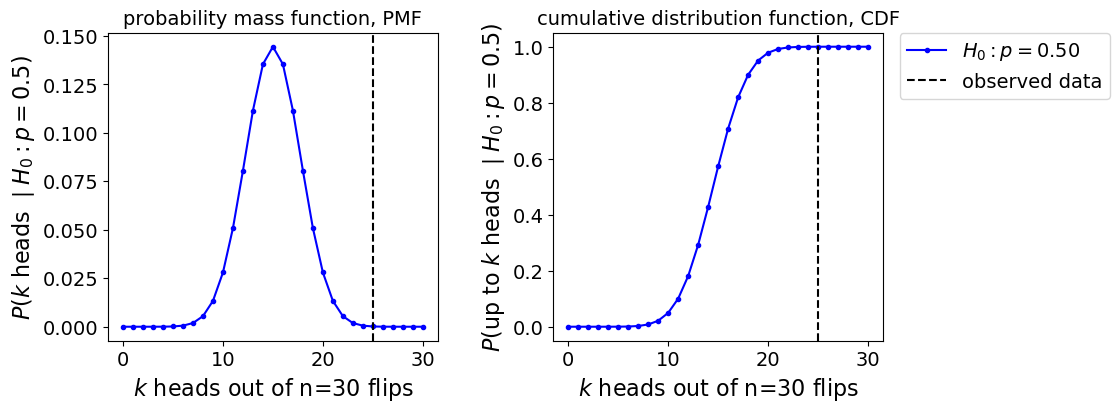

In [5]:
n_flips = 30
p_fair = 0.5
unlucky_k = 25
viz_coin_flip_H0_H1(k=unlucky_k, n=n_flips, p_null=p_fair, show_h1=False)

Call $H_0$ the null, or "fair" hypothesis that the booth manager's coin's chance of heads is $p = 0.5$. The p-value of the data is the probability that you would observe data at least as extreme as the data you observed, given the null hypothesis is true. In our case, we'll consider "extreme" to be one-sided -- the higher $k$ is, the more money we lose.

The total area under a PMF is 1. Graphically, the p-value for our observed data is the area to the right of the dashed line on the PMF plot. A convenient way to compute this value is with the CDF:

$$\begin{aligned}
\text{p-value} &= P(X \geq k \text{ heads} \mid H_0: p = 0.5) \\
&= \sum_{q = k}^n P(X = q \text{ heads} \mid H_0: p = 0.5) \\
&= 1 - \sum_{q = 0}^{k-1} P(X = q \text{ heads} \mid H_0: p = 0.5) \\
&= 1 - CDF(k-1 \text{ heads} \mid H_0: p = 0.5)
\end{aligned}$$

The p value can be computed as $1 - CDF(25-1)$:

In [6]:
1 - stats.binom.cdf(unlucky_k - 1, n=n_flips, p=p_fair)

0.00016245711594820023

To be more safe, use the "survival function" `sf`, which is optimized for dealing with small probabilities that `1-CDF` might just call 0:

In [7]:
stats.binom.sf(unlucky_k - 1, n=n_flips, p=p_fair)

0.00016245711594820025

Oof, if the coin was indeed fair, the chance that we'd be this unlucky or even unluckier is 0.00016. This seems quite unlikely. So unlikely, in fact, that why don't we formulate a new, better hypothesis given our observed data?

### Specifying a new hypothesis / parameter estimation


Next, we will demonstrate maximum likelihood estimation (MLE) on two specific probability distributions. A discrete distribution, the binomial; and a continuous distribution, the normal. 

### MLE for a binomial distribution

Let's come back to the coin flip example, where the data is some observed $k$ heads out of $N$ flips. We will try to find the per-trial chance of heads $p$ that maximizes the likelihood:

$$P(D|p) = P(k,N|p) = L(p) = {N \choose k}p^k (1-p)^{N-k} $$

What can we do here? We could plug in a bunch of $p$'s, evaluate this function, and then store the $p$ with the highest likelihood. 

Or, with this rather simple equation, we can solve by hand by taking a partial derivative of $L(p)$ with respect to $p$ and finding the $p$ that satisfies $\frac{\partial}{\partial p} L(p) = 0$.

So, taking the derivative:

$$\frac{\partial}{\partial p}L(p) = {N \choose k} kp^{k-1}(1-p)^{N-k} - p^k{N-k}(1-p)^{N-k-1} $$

This is a little gross. There's a lot of chained $p$'s and exponents to deal with.

A convenient trick that comes up frequently with this kind of problem is to maximize the log likelihood instead of the likelihood. This is okay to do because the logarithm is a monotonically increasing function (the $x$ that maximizes $f(x)$ also maximizes $\log f(x)$). Exponents come up a lot in statistics formulas, and taking the log helps to separate them out.

The log likelihood:

$$\begin{aligned}
\log L(p) &= \log \bigg[ {N \choose k}p^k (1-p)^{N-k}\bigg] \\ 
&= \log {N \choose k}+ k \log(p) + (N-k)\log(1-p) 
\end{aligned}$$

Now it's a little easier to take the derivative with respect to $p$:

$$\begin{aligned}
\frac{\partial}{\partial p} \log L(p) &= \frac{\partial}{\partial p} \bigg[ \log {N \choose k}+ k \log(p) + (N-k)\log(1-p)  \bigg] \\ 
&= \frac{k}{p} - \frac{N-k}{1-p}
\end{aligned}$$

Setting it to zero to find our maximizer, $\hat{p}$ (you should check it's a maximum by taking the second derivative too):

$$\frac{k}{p} - \frac{N-k}{1-p} = 0 \implies k - kp = Np - kp \implies \hat{p} = \frac{k}{N}$$

Rather unsurprisingly, if we observe $k$ heads out of $N$ flips, the maximum likelihood estimate of the probability of heads is just $k/N$.

So, we can set a new hypothesis, $H_1$, that explains our observed data. Let's plot it on the same plot as $H_0$ for comparison. This new distribution predicts the data much better -- it must be true, right? $H_0$ is just wrong!

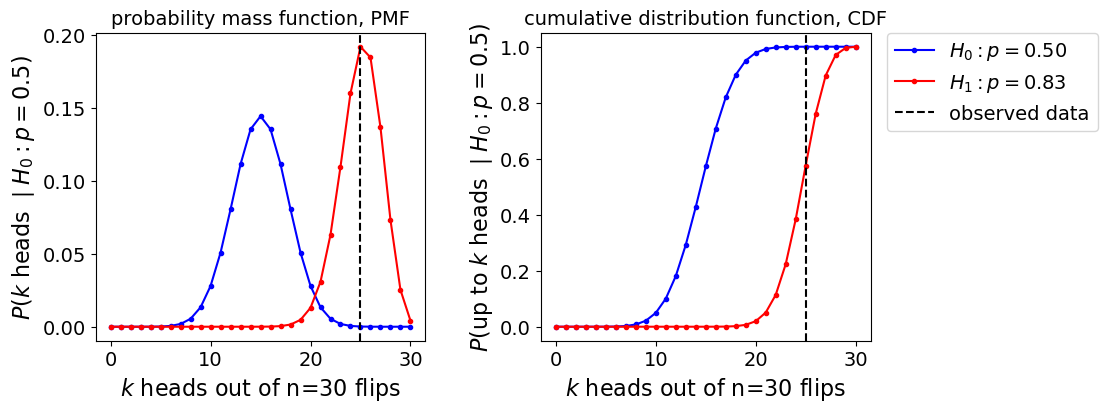

In [8]:
viz_coin_flip_H0_H1(k=unlucky_k, n=n_flips, p_null=p_fair, show_h1=True)

Let's pause here to think about the flow of logic in these conclusions.

- Does the fact that our data reject the null hypothesis validate $H_1$?

- the $H_1$ PDF describes this particular experiment very well (because it's the MLE!). Does it mean that it is the correct model?

- How many alternative distributions are potentially consistent with our observed data?

- What happens if our null hypothesis is poorly formulated or incorrect? Or our experiment does not directly test the null hypothesis?

- Finally, what if the priors on our two hypotheses - $H_0$ and $H_1$ - are not equal?

### MLE for a normal distribution

Now let's switch gears to something a little more involved. Suppose we observe $n$ data points $x_1, \dots, x_n \sim N(\mu, \sigma)$. Just as we did for binomial distribution, let's try to maximize the likelihood of the observed data with respect to the parameters that describe it.

For a single point $x$, the normal probability density function is

$$P(x| \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

The joint probability of $n$ points, assuming they are all independently, identically distributed:


$$\begin{aligned}
P(x_1, \dots, x_n \mid \mu, \sigma^2) &= P(x_1 \mid \mu, \sigma^2)\cdot P(x_2 \mid \mu, \sigma^2)\dots P(x_n \mid \mu, \sigma^2) && \text{assume data is IID} \\
&= \prod_{i=1}^n P(x_i \mid \mu, \sigma^2) && \text{use index notation} \\
&= \prod_{i=1}^n \frac{1}{\sqrt{2\pi\sigma^2}} \exp\big(-\frac{(x_i-\mu)^2}{2\sigma^2} \big) && \text{plug in PDF}\\
&= \bigg(\frac{1}{\sqrt{2\pi\sigma^2}}\bigg)^n \times \bigg[ \prod_{i=1}^n \exp\big(-\frac{(x_i-\mu)^2}{2\sigma^2} \big) \bigg] && \text{pop out the constant from the product}\\
&= \big(2\pi\sigma^2\big)^{-\frac{n}{2}} \times \bigg[ \prod_{i=1}^n \exp\big(-\frac{(x_i-\mu)^2}{2\sigma^2} \big) \bigg]&& \text{rewrite constant a little bit} \\
&= \big(2\pi\sigma^2\big)^{-\frac{n}{2}} \times \exp\bigg( -\sum_{i=1}^n \frac{(x_i-\mu)^2}{2\sigma^2} \bigg) && \text{product of logs is log of sum}\\
\end{aligned}$$

At this point it will be convenient to take the log again:

$$\begin{aligned}
\log P(x_1, \dots, x_n \mid \mu, \sigma^2) &= \log \bigg[ \big(2\pi\sigma^2\big)^{-\frac{n}{2}} \times \exp\bigg( -\sum_{i=1}^n \frac{(x_i-\mu)^2}{2\sigma^2} \bigg) \bigg] \\
&=  -\frac{n}{2}\log\big(2\pi\sigma^2\big) + \log \bigg[ \exp \bigg( -\sum_{i=1}^n \frac{(x_i-\mu)^2}{2\sigma^2} \bigg) \bigg] \\
&=  -\frac{n}{2}\log\big(2\pi\sigma^2\big) - \sum_{i=1}^n \frac{(x_i-\mu)^2}{2\sigma^2} \\
\end{aligned}$$

#### MLE of $\mu$

$$\begin{aligned}
\frac{d}{d\mu} \log P(x_1, \dots, x_n\mid \mu, \sigma^2) &= 0 \\
\frac{d}{d\mu} \bigg( -\frac{n}{2}\log\big(2\pi\sigma^2\big) - \sum_{i=1}^n \frac{(x_i-\mu)^2}{2\sigma^2} \bigg ) &= 0 \\
\sum_{i=1}^N \frac{-\frac{d}{d\mu} (x_i-\mu)^2}{2\sigma^2} &= 0 \\
\sum_{i=1}^N \bigg( \frac{x_i-\mu}{\sigma^2} \bigg) &= 0
\end{aligned}$$

Multiplying both sides by $\sigma$ and rearranging gives us our likelihood-maximizing $\mu$:

$$\hat{\mu} = \frac{\sum_{i=1}^n x_i}{n}$$

The maximum likelihood estimate of the mean given some observed $x_i$'s is the sample mean.

#### MLE of $\sigma^2$

$$\begin{aligned}
\log P(x_1, \dots, x_n \mid \mu, \sigma^2) = \log L(\mu, \sigma^2) = -\frac{n}{2}\log\big(2\pi\sigma^2\big) - \sum_{i=1}^n \frac{(x_i-\mu)^2}{2\sigma^2} \\
\end{aligned}$$

Taking derivative wrt $\sigma^2$:


$$\frac{\partial}{\partial\sigma^2} \log L(\mu, \sigma^2) =  -\frac{n}{2\sigma^2} + \sum_{i=1}^n \frac{(x_i-\mu)^2}{2(\sigma^2)^2} = 0 $$

Skipping some steps here (it is a good exercise to do these calculations by hand), we arrive at our estimate:

$$\hat{\sigma^2} = \frac{1}{n}\sum_{i=1}^n (x_i-\mu)^2$$

This expression is not too surprising -- it's the average squared distance from the mean over all data points. 

### Estimation of Gaussian parameters only given data... the road to the T-distribution


Let's say we observe some small number of data points $x_1, \dots, x_n$ (around $n=5$) that we assume are generated by a Gaussian process, $x_1, \dots, x_n \sim N(\mu, \sigma^2)$, and we'd like to use the data to estimate $\mu$ and $\sigma$.

From our analysis above, 
- the maximum likelihood estimator for the mean is the sample mean: $\hat{\mu} = \bar{x} = \frac{1}{N} \sum_{i=1}^n x_i$
- the maximum likelihood estimator for the variance is: $\hat{\sigma^2} = \frac{1}{n} \sum_{i=1}^n (x_i - \mu)^2$

Wait a second. The MLE for the variance includes $\mu$, something we're trying to estimate with $\bar{x}$!

If we plug in $\bar{x}$ for $\mu$ to get a new estimator for the variance, $\hat{\sigma^2} = \frac{1}{n} \sum_{i=1}^n (x_i - \bar{x})^2$, it turns out that this estimator is biased. An estimator $\hat{\theta}$ of a parameter $\theta$ is a function of data and is biased if the expected value of $\hat{\theta}$ over all possible data is not exactly $\theta$. A small correction is needed to yield an unbiased estimator of the population variance: $\frac{1}{n-1}$ rather than $\frac{1}{n}$. This is the Bessel correction -- you can read more about it [here](https://en.wikipedia.org/wiki/Bessel%27s_correction) and [here](https://en.wikipedia.org/wiki/Bias_of_an_estimator#Sample_variance).

So, given some data, an unbiased estimator of the population variance is the (Bessel-corrected) sample variance, $S^2 = \frac{1}{n-1}\sum_{i=1}^n (x_i - \bar{x})^2$

Let's see this in action. In the notebook you can use the function below to specify the true mean and standard deviation of a Gaussian, specify a number of data points $n$ to sample from that Gaussian, and visualize what an "estimated" Gaussian would look like, with mean $\bar{x}$ and standard deviation $S = \sqrt{\frac{1}{n-1}\sum_{i=1}^n (x_i - \bar{x})^2}$.

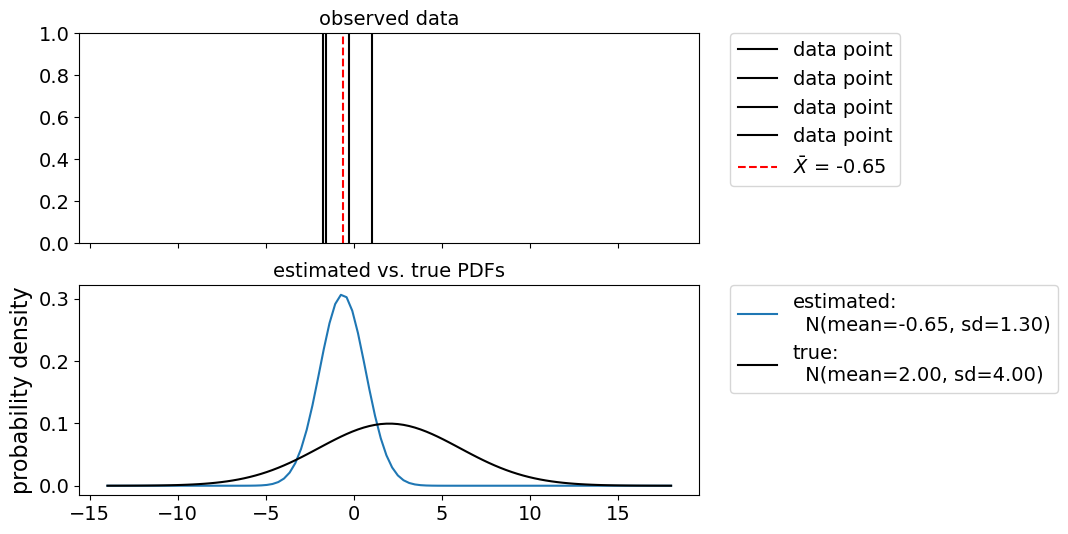

random seed: 290
inputs:
	n: 4
	true mu: 2.00
	true sigma: 4.00
estimates:
	Xbar: -0.65
	S: 1.30
4 generated data points:
	[-1.75485318 -1.5817379  -0.3070837   1.03787662]


In [12]:
estimate_normal_from_sample(n=4, true_mu=2, true_sigma=4)

Spend some time playing around with this. If you like the result from a particular random seed, you can input it into the function. Roughly how big does $n$ need to be to make the estimated PDF overlap with the true PDF?

#### The distributions of $\bar{x}$ and $S$
Now, let's fix a true $\mu$ and $\sigma$ for a Gaussian and set a number $n$ of datapoints. We will generate a sample of $n$ datapoints, compute $\bar{x}$ and $S$ as our estimates for $\mu$ and $\sigma$, store them, and then repeat this sample generation some large number of times.

Our goal is to make histograms for $\bar{x}$ and $S$ to see what their distributions look like.

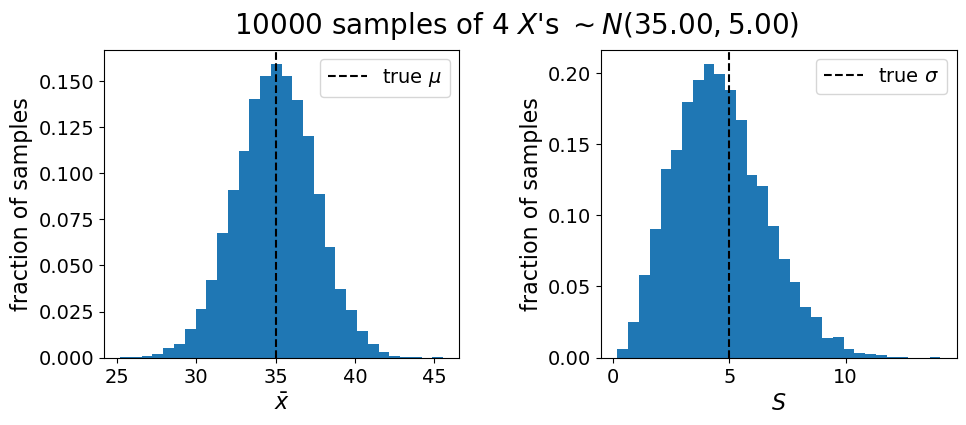

In [15]:
n = 4
true_mu = 35
true_sigma = 5
all_Xs, all_Xbars, all_Ses = get_dist_of_xbar_and_S(n, true_mu, true_sigma, n_experiments=10000)

What we should see here is that the distribution of $\bar{X}$ looks like a normal centered around the true $\mu$. This is consistent with the expression for $\bar{X} = \frac{1}{n} \sum_{i=1}^n x_i$. A sum of normals is [still a normal](https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables), and any multiplicative factor on a normally distributed variable is still normally distributed, the distribution is just scaled.

The distribution of $S$, the sample standard deviation, looks a little different. It's rather skewed, and it's not symmetric around the true $\sigma$ (at low $n$ at least -- though you should test what happens if $n$ is large). At low $n$, the bulk of the $S$'s are lower than the true $\sigma$, indicating that most of the time, the sample standard deviation underestimates the population standard deviation. 

What is up with this shape? Recall that $S = \sqrt{\frac{1}{n-1}\sum_{i=1}^n (x_i - \bar{x})^2}$ -- it is the square root of a sum of *squared* normals. In general, the sum of $K$ independent squared standard normal random variables follows a [$\chi^2$ distribution](https://en.wikipedia.org/wiki/Chi-square_distribution) with $K$ degrees of freedom. In our case, there are $n-1$ independent terms (given $\bar{X}$ and the first $n-1$ $X_i$'s, you can always compute what the $n$th one is), so $n-1$ degrees of freedom. 

#### Scoring data

Given a sample of data $X_1, \dots, X_n$ and a computed $\bar{X}$, if we assume the underlying population is $\mu_0$, how likely is it that we'd observe this particular $\bar{X}$?

To figure this out, $\bar{X} - \mu_0$ is of key importance. I would be willing to reject the hypothesis that $\mu_0$ is the mean of $X$ if my $\bar{X}$ is much larger than $\mu_0$. But how large is large? How far off would I expect $\bar{X}$ to be from the population mean by chance? The distance needs to be put in context. 

A natural unit is the standard deviation of $\bar{X}$, which is a "typical" distance a particular $\bar{X}$ is away from the population mean. We can find the standard deviation of $\bar{X}$ by working with its square, variance: $[SD(\bar{X})]^2 = Var(\bar{X})$:

$$\begin{aligned}
Var(\bar{X}) &= Var\big( \frac{1}{n} \sum_{i=1}^n X_i \big) = \frac{1}{n^2} Var\big( \sum_{i=1}^n X_i \big) = \frac{1}{n^2}  \sum_{i=1}^n Var( X_i ) = \frac{1}{n^2} \big[  n Var( X ) \big] = \frac{1}{n} \sigma^2\\
\end{aligned}$$

So, $SD(\bar{X}) = \frac{\sigma}{\sqrt{n}}$.

With this unit in place, we now have a "standard score" describing the number of standard deviations away $\bar{X}$ is from a putative mean $\mu_0$: 
$$\text{standard score} = \frac{\bar{X} - \mu_0}{SD(\bar{X})} = \frac{\bar{X} - \mu_0}{\sigma / \sqrt{n}}$$

Note that this score depends on $\sigma$! 

**If we know $\sigma$**, then the denominator is a constant, and the only randomness that's left is within $\bar{X}$, a sum of normal random variables, making the entire term a normal random variable. This kind of score is called a Z score: 

$$ Z = \frac{\bar{X} - \mu_0}{\sigma / \sqrt{n}}$$ 

Z scores follow a standard normal distribution, $N(0, 1)$, making it easy to set quantiles to determine cutoffs for p-values and do other calculations.

**If we don't know $\sigma$**, we need to estimate it with the sample standard deviation, $S = \sqrt{\frac{1}{n-1}\sum_{i=1}^n (X_i - \bar{X})^2}$. We replace $\sigma$ with $S$ to get what's called a T score:

$$ T = \frac{\bar{X} - \mu_0}{S / \sqrt{n}}$$ 

T scores follow [Student's t distribution](https://en.wikipedia.org/wiki/Student's_t-distribution) with $n-1$ degrees of freedom. If $Z$ is a standard normal random variable, and $V$ follows a $\chi^2$-distribution with degrees of freedom $\nu$, then $\frac{Z}{\sqrt{V/\nu}}$ follows Student's t-distribution with $\nu$ degrees of freedom. The T score written above follows this exact form, as $\bar{x}$ is a sum of normals, and $S$ is the square root of a sum of $n-1$ independent squared normals, divided by $n-1$. 

So, some takehome messages:
- if $\sigma$ is known, we can do hypothesis testing on $\bar{X}$ by computing a Z score, which follows a standard normal ($N(0, 1)$) distribution
- if $\sigma$ is unknown, we compute a T score with our sample standard deviation $S$ in the denominator instead. Such scores follow Student's t distribution with $n-1$ degrees of freedom. $S$ depends on the data, and has considerable spread, as seen in the histogram above -- it's not a constant!

### T vs Z distributions

Let's actually compare the distribution of Z scores vs. the distribution of T scores by taking the samples above and building histograms of $ Z = \frac{\bar{X} - \mu}{\sigma / \sqrt{n}}$  and $ T = \frac{\bar{X} - \mu}{S / \sqrt{n}}$

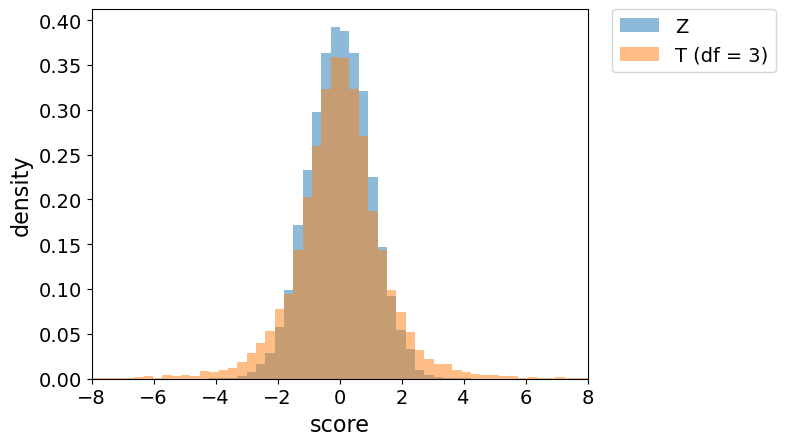

In [16]:
# uses the samples computed in previous code cell

# compute Z scores with true mu, true sigma
all_Zs = (all_Xbars - true_mu)/(true_sigma / np.sqrt(n))

# compute T scores plugging in S for true sigma
all_Ts = (all_Xbars - true_mu)/(all_Ses / np.sqrt(n))

# find min/max for nice plotting
totmin = min((min(all_Zs), min(all_Ts)))
totmax = max((max(all_Zs), max(all_Ts)))

# plot histogram
plt.figure()
b = np.linspace(totmin, totmax, 200)
plt.hist(all_Zs, bins=b, density=True, alpha=0.5, label='Z')
plt.hist(all_Ts, bins=b, density=True, alpha=0.5, label='T (df = {})'.format(n-1))
plt.xlim(-8, 8); plt.ylabel('density'); plt.xlabel('score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

It looks like the distribution of T scores has fatter tails, giving more weight to outliers, than the Z distribution. 

The T distribution allows for $\bar{X}$ to be "far away" from $\mu$ because we had to estimate the true variance. The data could have had a small sample variance, making us underestimate the true variance, making us overestimate the "distance" between $\bar{X}$ and $\mu$. The T distribution gives more probability to large magnitude T scores that the Z distribution would say is unlikely.

Try changing $n$ around a bit. How does the distribution of T scores compare to Z scores at large $n$? Why? Hint: does more data help us estimate the true variance better?

We've made it! 

We have arrived at a t distribution through computing a standard score of a sample mean of normally distributed datapoints with an estimate of the population variance. The homework will show us another way the t distribution arises in a Bayesian setting, where we find the marginal distribution of the mean of a normal distribution, marginalizing over different possible variances.